## Imports and Constant Definitions

In [1]:
import netCDF4 as nc
import pandas as pd
from datetime import datetime
from scipy.constants import Boltzmann
from scipy import log
import numpy as np

In [2]:
month_dict = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June",
    7: "July", 8: "August", 9: "September", 10: "October", 11: "November", 12: "December"}

seasons_for_days = {
    'Winter': list(range(305, 366)) + list(range(1, 32)),
    'Spring': list(range(32, 121)),
    'Summer': list(range(121, 213)),
    'Autumn': list(range(213, 305))
}

## Load Data
### You can run this segment only once and save the csv file. From next time you can just load the previously saved csv file.

In [3]:
def get_dataframe_from_nc_file(nc_file_path):
    ds = nc.Dataset(nc_file_path)
    longitude = ds['longitude'][:]
    latitude = ds['latitude'][:]
    level = ds['level'][:]
    time = ds['time']
    time_convert = nc.num2date(time[:], time.units, time.calendar)[:]
    t = ds['t'][:]
    
    rows = []
    for time_i, a in enumerate(t):
        for level_i, b in enumerate(a):
            for lat_i, c in enumerate(b):
                for lon_i, d in enumerate(c):
                    rows.append({
                        'Latitude': latitude[lat_i],
                        'Longitude': longitude[lon_i],
                        'Time': time_convert[time_i],
                        'PressureLevel': level[level_i],
                        'Temperature': d
                    })
    df = pd.DataFrame(rows)
    df.to_csv(f'{nc_file_path[:-3]}.csv')
    return df
    

In [4]:
def get_average_temperature_of_a_day(df):
    df['date_only'] = df.apply(lambda x: datetime.strptime(str(x['Time']),'%Y-%m-%d %H:%M:%S').date(), axis=1)
    df = df.groupby(['date_only', 'PressureLevel'], as_index=False)['Temperature'].mean()
    return df

In [5]:
def convert_pressure_to_altitude(p_level, temp):
    P0 = 101325
    P = p_level * 100
    H = 7
    return H * log(P0/P)
    

In [6]:
def get_season_for_month(month):
    if month in [1, 11, 12]:
        return 'Winter'
    elif month in [2, 3, 4]:
        return 'Spring'
    elif month in [5, 6, 7]:
        return 'Summer'
    elif month in [8, 9, 10]:
        return 'Autumn'
    else:
        raise ValueError

In [7]:
dfs = []
nc_file_list = ['2020_jan2apr.nc', '2020_may2aug.nc', '2020_sep2dec.nc']

for file in nc_file_list:
    df = get_dataframe_from_nc_file(file)
    df = get_average_temperature_of_a_day(df)
    dfs.append(df)

In [8]:
final_df = pd.concat(dfs).reset_index(drop=True)

In [9]:
final_df['Day'] = final_df.apply(lambda x: x['date_only'].timetuple().tm_yday, axis=1)
final_df['Month'] = final_df.apply(lambda x: x['date_only'].month, axis=1)
final_df['Height'] = final_df.apply(lambda x: convert_pressure_to_altitude(x['PressureLevel'], x['Temperature']), axis=1)
final_df['Season'] = final_df.apply(lambda x: get_season_for_month(x['Month']), axis=1)

/home/lenovo/miniconda3/envs/manisha/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.log is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.log instead
  """


In [10]:
final_df.to_csv('netcdf_data_2020.csv', index=False)

# Visualization

In [11]:
final_df = pd.read_csv('netcdf_data_2020.csv')

In [27]:
final_df.describe()

,PressureLevel,Temperature,Day,Month,Height
count,13542.000000,13542.000000,13542.000000,13542.000000,13542.000000
mean,420.216216,254.583553,183.500000,6.513661,12.853302
std,352.527776,32.015378,105.658606,3.451361,13.781404
min,1.000000,190.659020,1.000000,1.000000,0.092141
25%,70.000000,225.982229,92.000000,4.000000,1.876387
50%,350.000000,257.889259,183.500000,7.000000,7.440896
75%,775.000000,285.092506,275.000000,10.000000,18.706961
max,1000.000000,307.042378,366.000000,12.000000,48.446428


In [13]:
# create a dataframe which contains temperature values for all 365 days,
# columns represent temperature for each heights and rows contain temperatures for each day

all_df = pd.DataFrame()
all_df['Day'] = final_df['Day'].unique()

group = final_df.groupby(['Height'])
for height, df in group:
    all_df[height] = df['Temperature'].values
all_df

,Day,0.09214090568396603,0.2693655615739949,0.45119396639682,0.6378716959719493,0.8296645152887496,1.026860654055624,1.229773412168391,1.4387441542161592,1.6541457648834346,...,18.70696116421341,21.062266820561906,24.638046186923837,27.476301943680987,32.32833220760061,34.82505681517173,37.180362471520226,40.756141837882154,43.59439759463931,48.446427858558934
0,1,293.425336,292.064299,290.258556,289.125951,286.787659,285.683129,284.141706,282.310204,280.348459,...,211.240506,213.791600,217.362204,218.912238,229.267331,232.712613,236.961348,248.348615,257.388546,262.410416
1,2,292.023851,290.680542,288.998747,287.743062,285.713519,284.561449,282.898684,281.419054,279.681037,...,211.489849,215.155675,217.349831,218.378170,227.209279,231.444989,237.821601,247.643423,254.722332,260.946271
2,3,290.196763,288.874365,287.400451,285.922486,284.411887,282.834214,281.301112,279.663744,277.828189,...,210.815047,213.599419,216.140962,218.743790,225.126480,230.367954,236.423156,244.493719,249.348517,255.627447
3,4,289.317624,287.949425,286.512196,285.032132,283.528552,281.943932,280.278562,278.790177,277.324295,...,208.240872,212.738370,215.656097,220.110471,225.644195,230.875901,235.443152,244.093440,250.098860,252.087377
4,5,288.027860,286.678545,285.247901,283.783973,282.311940,280.764657,279.164263,277.986796,276.853250,...,206.216899,211.533987,215.544088,219.764459,226.770433,230.754486,235.833374,243.622468,250.760276,251.926962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,362,292.770982,291.316772,289.965907,288.431946,286.912081,285.406312,283.727398,283.481210,283.194017,...,196.982330,205.839654,217.751707,222.501784,228.460110,228.636798,232.803292,244.074926,258.512022,267.480454
362,363,292.529694,291.080987,289.738489,288.189377,286.661371,285.190578,283.677346,282.782749,281.770411,...,198.182589,207.294090,217.387024,221.693044,227.368699,231.196063,237.069512,246.260312,256.450032,262.756232
363,364,292.553514,291.209734,289.759369,288.234755,286.722730,285.165854,283.621792,282.186427,280.992350,...,197.217965,208.194189,216.554313,220.349113,225.987531,232.871887,240.868308,249.779602,256.539733,256.230228
364,365,292.928449,291.608489,290.124655,288.624464,287.121484,285.636444,284.272689,283.218289,282.277108,...,199.290960,205.955737,216.103773,219.818974,224.656792,230.435942,236.361327,250.783800,257.566545,254.029993


In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

### Line Plot (Month-wise)

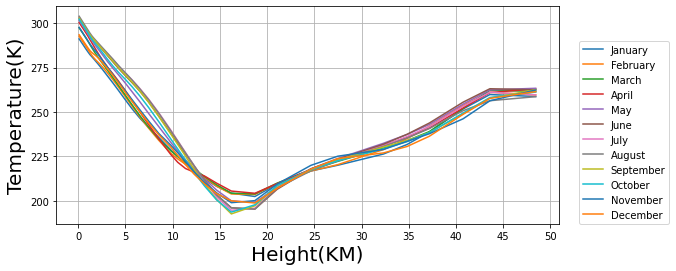

In [15]:
fig,ax = plt.subplots(1, figsize=(9,4))

month_df = final_df.groupby(['Month','Height'], as_index=False)['Temperature'].mean()
group_month = month_df.groupby(['Month'])

for month, df in group_month:
    heights = df["Height"].values
    avg_temp = df["Temperature"].values
    ax.plot(heights, avg_temp, label=month_dict[month])
    
ax.set_xlabel("Height(KM)", fontsize=20)
ax.set_ylabel("Temperature(K)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_netcdf.pdf')
plt.show()

### Line Plot (Season-wise)

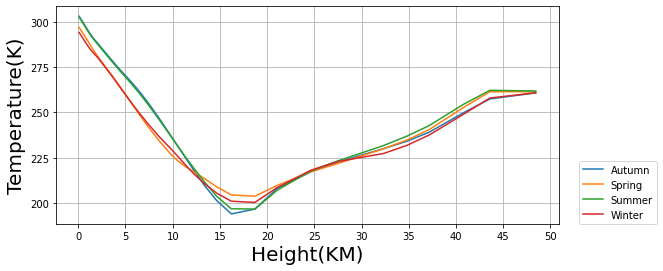

In [16]:
fig,ax = plt.subplots(1, figsize=(9,4))

season_df = final_df.groupby(['Season','Height'], as_index=False)['Temperature'].mean()
group = season_df.groupby(['Season'])

for season, df in group:
    heights = df["Height"].values
    avg_temp = df["Temperature"].values
    ax.plot(heights, avg_temp, label=season)
    
ax.set_xlabel("Height(KM)", fontsize=20)
ax.set_ylabel("Temperature(K)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(25))
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_netcdf.pdf')
plt.show()

### Contour Plot

In [164]:
new_indices = list(range(31, len(all_df))) + list(range(0, 31))
contour_df = all_df.drop(['Day'], 1)
contour_df = contour_df.reindex(new_indices)
contour_df
contour_df.to_csv('contour_data.csv')

/home/lenovo/miniconda3/envs/manisha/lib/python3.6/site-packages/ipykernel_launcher.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator


(0.0, 50.0)

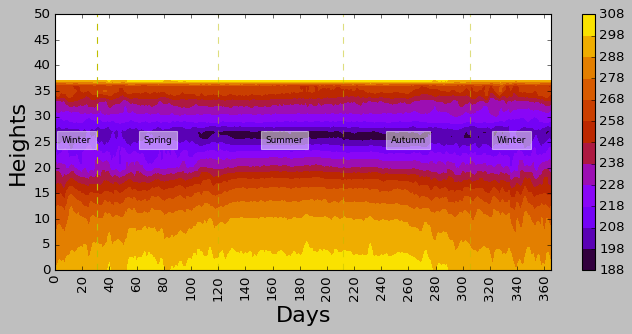

In [189]:
# get values for heights
heights = final_df['Height'].values

# get the dataframe values as numpy matrix
all_data = contour_df.to_numpy()
contour_data = all_data.T # transpose the data to plot days in x-axis of contour plot

contour_data= np.vstack((contour_data,contour_data[0])) # done from example code from rejina.ipynb, why????

plt.style.use('classic') # style from rejina.ipynb
fig,ax = plt.subplots(1, figsize=(10,4))
gap = 10
c_levels = np.arange(188,309,gap) # set levels of temperature at which to draw contours and label colorbar
cs = ax.contourf(contour_data, levels=c_levels, cmap='gnuplot') # style from rejina.ipynb
cbar = fig.colorbar(cs)
cbar.set_ticks(c_levels) # set labels in the colorbar

# Uncomment this section if you want fine lines for contour levels
# cnt = ax.contour(contour_data, levels=levels, colors='k') # colors from rejina.ipynb, to draw contour lines
# for c in cnt.collections:
#     c.set_linewidth(0.5) # change this value to change width of contour lines


# uncomment following to set dashed lines like grid, change the ranges as per need
# ax.hlines(range(0,241, 50),0,365,linestyle='--')
# ax.vlines(range(0,365, 25),0,241,linestyle='--')

# These are the new codes added on June 14, 2020
a1=0.5
h = 25
ax.axvline(x=31, color='y', linestyle='--', alpha=1)
ax.axvline(x=120, color='y', linestyle='--', alpha=0.5)
ax.axvline(x=212, color='y', linestyle='--', alpha=0.5)
ax.axvline(x=305, color='y', linestyle='--', alpha=0.5)

# Comment following if you don't want the text.
t1 = ax.text(5, h, 'Winter', fontsize=8)
t2 = ax.text(65, h, 'Spring', fontsize=8)
t3 = ax.text(155, h, 'Summer', fontsize=8)
t4 = ax.text(247, h, 'Autumn', fontsize=8)
t5 = ax.text(325, h, 'Winter', fontsize=8)
t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t3.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t4.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))
t5.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))

ax.set_xlabel("Days", fontsize=20)
ax.set_ylabel("Heights", fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(20)) # put ticks in x-axis for every 10 points
ax.set_xticklabels(ax.get_xticks().astype(int), rotation = 90) # set labels in x-axis

# todo: write understandable code segment for following
ax.yaxis.set_major_locator(MultipleLocator(5)) # put ticks in y-axis for every 20 points
# ax.set_yticklabels(np.arange(heights[0], heights[-1]+1, 10)) # set labels in y-axis

plt.ylim([0, 50])

# Pauses

## Estimation of Pauses

In [166]:
from scipy.signal import argrelextrema

In [167]:
def filter_consecutive(data, stepsize=1):
    '''
    filter consecutive indices according to stepsize
    eg 1: if array of indices for minimas is [2,3,4, 9,10, 15] and stepsize is 1, it will return [2, 4, 9, 15]
    eg 2: if array of indices for minimas is [2,3,4, 9,10, 15] and stepsize is 2, it will return [2, 9, 15]
    '''
    consec = np.split(data, np.where(np.diff(data) != stepsize)[0]+1)
    return [x[0] for x in consec]

In [168]:
def filter_extremas(x, max_index):
    '''
    filter unique points of extremas and ignore the endpoints of an array
    ex: in an array [0, 1, 2, 2, 2, 1, 0], maxima can be at indices 2, 3, 4 at values 2, 2, 2
    this function returns only a single index for such case (in former example returns the index 2)
    '''
    x = np.array(filter_consecutive(x)) # filter consecutive indices whose differences is 1
    x = np.array(filter_consecutive(x, stepsize=2)) # filter consecutive indices whose differences is 2
    if x[0] == 0: # if left end is an extrema, ignore it
        x = x[1:]
    if x[-1] == max_index: # if right end is an extrema, ignore it
        x = x[:-1]
    return x

In [169]:
def extract_maxima(x, y):
    '''
    get unique maxima for Stratopause at a height between 20KM and 50KM
    the height was chosen according to position of maximas seen in above line plots
    '''
    indices = argrelextrema(x, np.greater_equal)[0] # returns all maximas obtained in an array sequence
    indices = filter_extremas(indices, 240) # filter duplicate consecutive maximas and maximas at endpoints
    final_indices = [] # initialize indices for stratopause
    for i in indices:
        if 35 < y[i] < 50:
            final_indices.append(i)
    return {
        'stratos_temp': x[final_indices],
        'stratos_height': y[final_indices]
    }
def extract_minima(x, y):
    '''
    get unique minimas for Tropopause and Mesopause
    at a height between 0KM and 20KM (for Tropopause) and between 55KM and 120KM (for Mesopause)
    the height was chosen according to position of minimas seen in above line plots
    '''
    indices = argrelextrema(x, np.less_equal)[0] # returns all minimas obtained in an array sequence
    indices = filter_extremas(indices, 240) # filter duplicate consecutive minimas and minimas at endpoints
    t_indices = [] # initialize indices for tropopause
    s_indices = [] # initialize indices for mesopause
    for i in indices:
        if 13 < y[i] <= 20:
            t_indices.append(i)
        if 55 <= y[i] <=120:
            s_indices.append(i)
    return {
        'tropos_temp': x[t_indices],
        'tropos_height': y[t_indices],
        'mesos_temp': x[s_indices],
        'mesos_height': y[s_indices]
    }

In [170]:
def get_extrema_item(extrema):
    if len(extrema) != 0:
        return extrema.item()
    else:
        return -100 # default value

In [171]:
def get_season_for_day(day):
    seasons = seasons_for_days.keys()
    for season in seasons:
        if day in seasons_for_days[season]:
            return season

In [172]:
all_df__ = all_df.set_index('Day')
all_df_transposed = all_df__.T
days = all_df_transposed.columns

heights = all_df__.columns.values
rows = []
for day in days:
    temperatures = all_df_transposed[day].values
    minimas = extract_minima(temperatures, heights) # get unique minimas for Tropopause and Mesopause
    maximas = extract_maxima(temperatures, heights) # get unique maxima for Stratopause

    rows.append({
        'Day': day,
        'Tropopause_temp': get_extrema_item(minimas['tropos_temp']),
        'Stratopause_temp': get_extrema_item(maximas['stratos_temp']),
        'Mesopause_temp': get_extrema_item(minimas['mesos_temp']),
        'Tropopause_height': get_extrema_item(minimas['tropos_height']),
        'Stratopause_height': get_extrema_item(maximas['stratos_height']),
        'Mesopause_height': get_extrema_item(minimas['mesos_height']),

    })

pauses_df = pd.DataFrame(rows)
pauses_df['Season'] = pauses_df.apply(lambda x: get_season_for_day(x['Day']), axis=1)

In [173]:
pauses_df.describe()

,Day,Tropopause_temp,Stratopause_temp,Mesopause_temp,Tropopause_height,Stratopause_height,Mesopause_height
count,366.000000,366.000000,366.000000,366.0,366.000000,366.000000,366.0
mean,183.500000,198.103150,262.080478,-100.0,17.358828,46.736286,-100.0
std,105.799338,4.513415,2.687513,0.0,1.253023,2.321163,0.0
min,1.000000,190.659020,251.926962,-100.0,14.648232,43.594398,-100.0
25%,92.250000,194.497640,260.437252,-100.0,16.210237,43.594398,-100.0
50%,183.500000,196.966162,262.275615,-100.0,16.210237,48.446428,-100.0
75%,274.750000,201.548146,263.926832,-100.0,18.706961,48.446428,-100.0
max,366.000000,210.482855,270.357516,-100.0,18.706961,48.446428,-100.0


## Line Plot of the Pauses

In [174]:
def line_plot_pause(pause):
    fig,ax = plt.subplots(1, 2, figsize=(14, 4))

    ax[0].plot(pauses_df['Day'].values, pauses_df[f'{pause}_temp'].values, label=pause)
    ax[0].set_xlabel('Days', fontsize = 16)
    ax[0].set_ylabel('Temperature', fontsize = 16)
    ax[0].grid()

    ax[1].plot(pauses_df['Day'].values, pauses_df[f'{pause}_height'].values, label=pause)
    ax[1].set_xlabel('Days', fontsize = 16)
    ax[1].set_ylabel('Height', fontsize = 16)
    ax[1].grid()


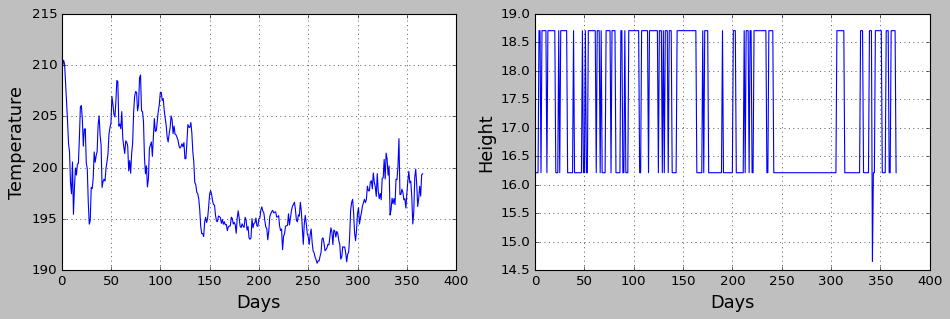

In [175]:
line_plot_pause('Tropopause')

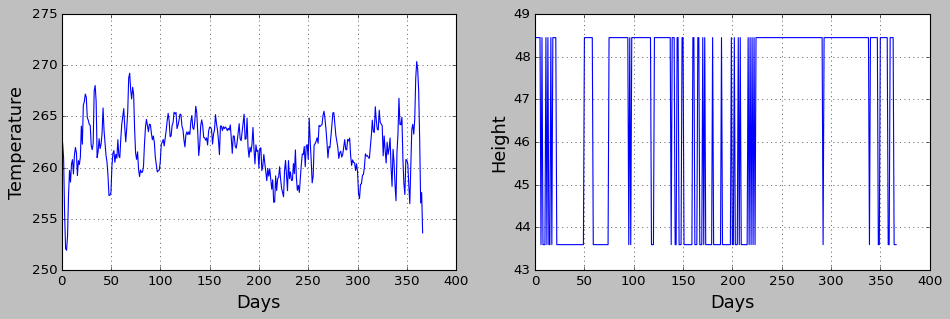

In [176]:
line_plot_pause('Stratopause')

# Vertical Profiles

In [177]:
# heights of tropopause, stratopause and mesopause estimated
topo_height = pauses_df['Tropopause_height'].mean()
strato_height = pauses_df['Stratopause_height'].mean()

## Vertical Profile (Season-wise) with Estimated Pauses

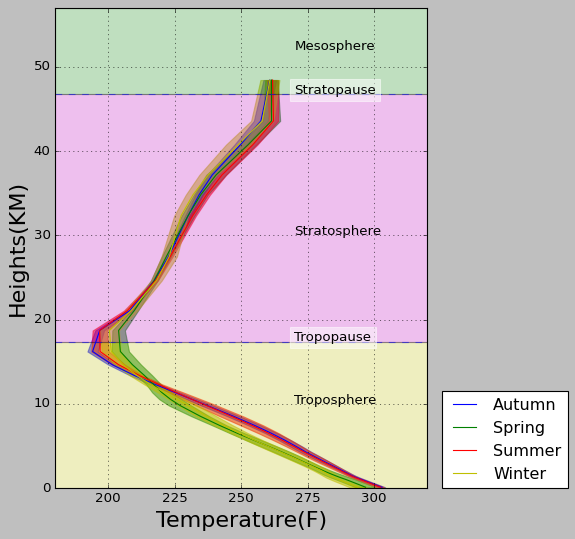

In [185]:
a1=0.5
text_loc_h = 270
colors = ['b', 'g', 'r', 'y']

fig,ax = plt.subplots(1, figsize=(6,7.5))

season_df = final_df.groupby(['Season','Height'], as_index=False).agg({'Temperature': ['mean', 'std']})
group = season_df.groupby(['Season'])

i = 0
for season, df in group:
    x =  df['Temperature', 'mean'].values
    y = df['Height'].values
    x_error = df['Temperature', 'std'].values
    
    ax.plot(x, y, label=season, color=colors[i]) # central line plot for each season
    ax.fill_betweenx(y, x-x_error, x+x_error, alpha=a1, edgecolor='dimgray', color=colors[i]) # plot std deviation as area with gray edge
    ax.set_xlabel('Height', fontsize=16)
    ax.set_ylabel('Temperature (K)', fontsize=16)
    i = i + 1

# give background colors to different layers of the atmosphere
plt.axhspan(0, topo_height, facecolor='y', alpha=0.25) # Troposphere region background color
plt.axhspan(topo_height, strato_height, facecolor='m', alpha=0.25)
plt.axhspan(strato_height, 57, facecolor='g', alpha=0.25)

# plot horizontal boundary lines at pauses
plt.axhline(y=topo_height, color='b', linestyle='--', alpha=0.5) # border for Troposphere and Stratosphere
plt.axhline(y=strato_height, color='b', linestyle='--', alpha=0.5)

plt.text(text_loc_h, 10, 'Troposphere')
plt.text(text_loc_h, 30, 'Stratosphere')
plt.text(text_loc_h, 52, 'Mesosphere')

t1 = plt.text(text_loc_h, topo_height + 0.1, 'Tropopause')
t2 = plt.text(text_loc_h, strato_height + 0.1, 'Stratopause')
t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))


ax.set_ylim(0,57)
    
ax.set_xlabel("Temperature(F)", fontsize=20)
ax.set_ylabel("Heights(KM)", fontsize=20)
ax.xaxis.set_major_locator(MultipleLocator(25)) # put ticks in x-axis for every 25 K
ax.yaxis.set_major_locator(MultipleLocator(10)) # put ticks in y-axis for every 10 KM
ax.grid()
plt.legend(loc=(1.04,0))
plt.savefig('./output/month_wise_line_plot_vertical.pdf')
plt.show()

In [186]:
def vertical_profile_seasonal(season, a1=0.5, a2=0.25):
    '''
    plot vertical temperature profile for a season and save it.
    '''
    a1=0.5
    text_loc_h = 270

    fig,ax = plt.subplots(1, figsize=(5,7.5))

    season_df = final_df.groupby(['Season','Height'], as_index=False).agg({'Temperature': ['mean', 'std']})
    group = season_df.groupby(['Season'])

    for s, _df in group:
        if s == season:
            df = _df
            break
    x =  df['Temperature', 'mean'].values
    y = df['Height'].values
    x_error = df['Temperature', 'std'].values

    ax.plot(x, y, label=season) # central line plot for each season
    ax.fill_betweenx(y, x-x_error, x+x_error, alpha=a1, edgecolor='dimgray') # plot std deviation as area with gray edge
    ax.set_xlabel('Height', fontsize=16)
    ax.set_ylabel('Temperature (K)', fontsize=16)

    # give background colors to different layers of the atmosphere
    plt.axhspan(0, topo_height, facecolor='y', alpha=0.25) # Troposphere region background color
    plt.axhspan(topo_height, strato_height, facecolor='m', alpha=0.25)
    plt.axhspan(strato_height, 57, facecolor='g', alpha=0.25)

    # plot horizontal boundary lines at pauses
    plt.axhline(y=topo_height, color='b', linestyle='--', alpha=0.5) # border for Troposphere and Stratosphere
    plt.axhline(y=strato_height, color='b', linestyle='--', alpha=0.5)

    plt.text(text_loc_h, 10, 'Troposphere')
    plt.text(text_loc_h, 30, 'Stratosphere')
    plt.text(text_loc_h, 52, 'Mesosphere')

    t1 = plt.text(text_loc_h, topo_height + 0.1, 'Tropopause')
    t2 = plt.text(text_loc_h, strato_height + 0.1, 'Stratopause')
    t1.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white')) # set white transparent background for text
    t2.set_bbox(dict(facecolor='white', alpha=a1, edgecolor='white'))


    ax.set_ylim(0,57)

    ax.set_xlabel("Temperature(F)", fontsize=20)
    ax.set_ylabel("Heights(KM)", fontsize=20)
    ax.xaxis.set_major_locator(MultipleLocator(25)) # put ticks in x-axis for every 25 K
    ax.yaxis.set_major_locator(MultipleLocator(10)) # put ticks in y-axis for every 10 KM
    ax.grid()
    plt.legend(loc=(1.04,0))
    plt.savefig('./output/month_wise_line_plot_vertical.pdf')
    plt.show()

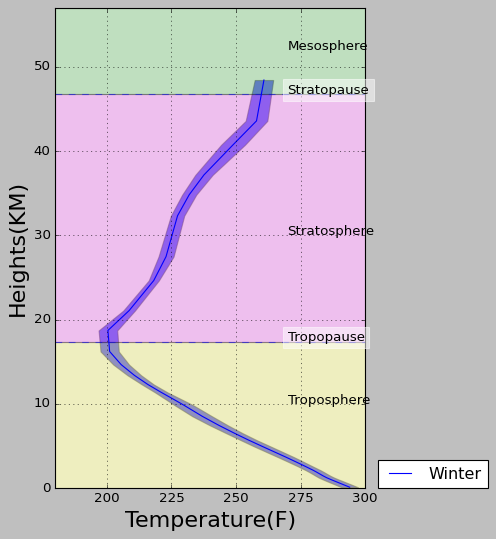

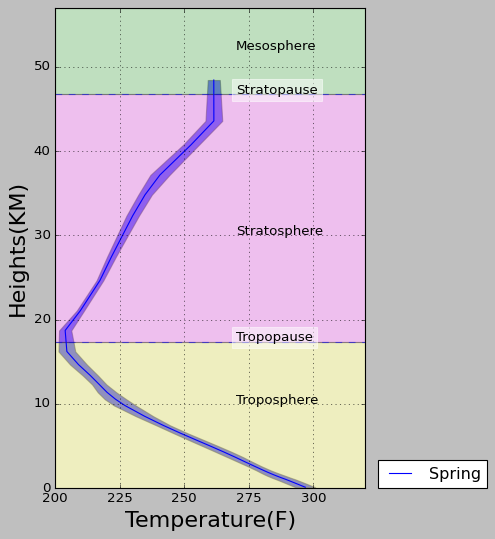

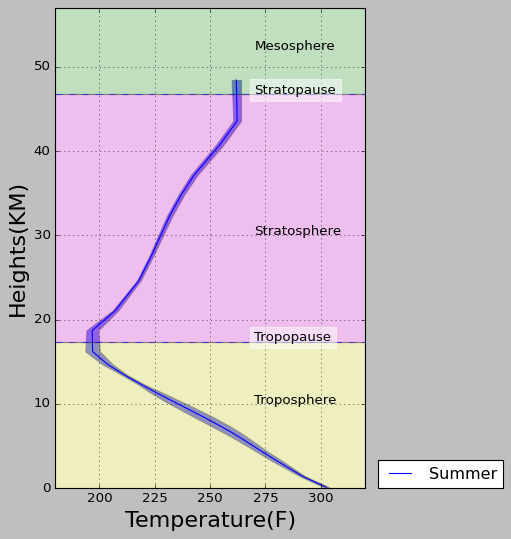

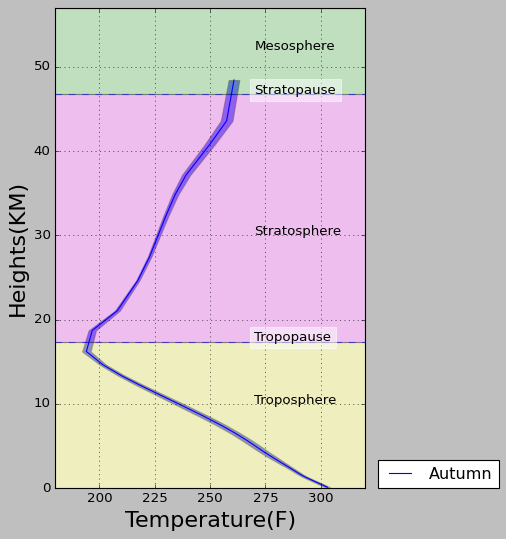

In [188]:
seasons = seasons_for_days.keys()
# seasons = ['Autumn', 'Winter', 'Spring']
for season in seasons:
    vertical_profile_seasonal(season)